In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob 
import keras
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color as scc

from skimage import io
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ID
from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam, Adamax
# from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

C:\Users\Sriya Nukala\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Sriya Nukala\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want t

In [17]:
pip install tensorflow

     -------------------------------------- 284.1/284.1 MB 2.9 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.9 MB/s eta 0:00:00
     ------------------------------------- 182.0/182.0 kB 10.7 MB/s eta 0:00:00
     -------------------------------------- 151.

In [1]:
pip install tensorflow_addons

     -------------------------------------- 719.8/719.8 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [21]:
dataset_path = r'C:\Users\Sriya Nukala\Downloads\Dataset\gaussian_filtered_images'
filepaths=[]
labels=[]

In [15]:
folds = os.listdir(dataset_path)

In [16]:
folds

['export.pkl', 'Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [22]:
for fold in folds:
    foldpath = os.path.join(dataset_path, fold)  
    # skip export.pkl file
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

In [24]:
img_paths = pd.Series(filepaths, name= 'filepaths')
img_labels = pd.Series(labels, name='labels')
dataset = pd.concat([img_paths, img_labels], axis= 1)

In [25]:
dataset

filepaths  labels
0     C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...    Mild
1     C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...    Mild
2     C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...    Mild
3     C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...    Mild
4     C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...    Mild
...                                                 ...     ...
3657  C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...  Severe
3658  C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...  Severe
3659  C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...  Severe
3660  C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...  Severe
3661  C:\Users\Sriya Nukala\Downloads\Dataset\gaussi...  Severe

[3662 rows x 2 columns]

In [52]:
batch_size=3662

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

gen=ID()
data_gen = gen.flow_from_dataframe( dataset,x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 3662 validated image filenames belonging to 5 classes.


In [53]:
img_data, img_labels = data_gen.next()

In [54]:
print(img_data.shape, img_labels.shape)

(3662, 224, 224, 3) (3662, 5)


In [55]:
img_labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [56]:
train_data, test_data, train_labels, test_labels = train_test_split(img_data, img_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [73]:
train_data.shape

(2196, 224, 224, 3)

In [92]:
train_data1 = train_data.reshape(-1, img_size[0] * img_size[1] * 3)
train_data1.shape

(2196, 150528)

In [93]:
smt=SMOTE()
train_data_sm,train_labels_sm=smt.fit_resample(train_data1,train_labels)
train_data_sm1=train_data_sm.reshape(-1,img_size[0] * img_size[1] * 3)

In [97]:
val_data1 = val_data.reshape(-1, img_size[0] * img_size[1] * 3)
val_data1.shape

(550, 150528)

In [98]:
val_data_sm,val_labels_sm=smt.fit_resample(val_data1,val_labels)
val_data_sm1=val_data_sm.reshape(-1,img_size[0] * img_size[1] * 3)

In [94]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))
# model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))
# model.add(TimeDistributed(Bidirectional(LSTM(64,return_sequences=True))))
model.add(Dropout(0.5))
# model.add(TimeDistributed(LSTM(32, return_sequences=True)))
model.add(Flatten()) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=5, activation="softmax"))

In [95]:
model = model

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

# CALLBACKS = [my_callback]


model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_15 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 dropout_18 (Dropout)        (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 112, 112, 64)    

In [99]:
EPOCHS = 10

history = model.fit(train_data_sm1, train_labels_sm, validation_data=(val_data_sm1, val_labels_sm),batch_size=50,epochs=EPOCHS)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Sriya Nukala\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_11" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150528)


In [28]:
train_data,test_data=train_test_split(dataset,test_size=0.25,random_state=42)

In [29]:
train_data,val_data=train_test_split(train_data,test_size=0.2,random_state=42)

In [31]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_gen = ID()
test_gen = ID()

train_generator = train_gen.flow_from_dataframe( train_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_generator = test_gen.flow_from_dataframe( val_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_generator = test_gen.flow_from_dataframe( test_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2196 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 916 validated image filenames belonging to 5 classes.


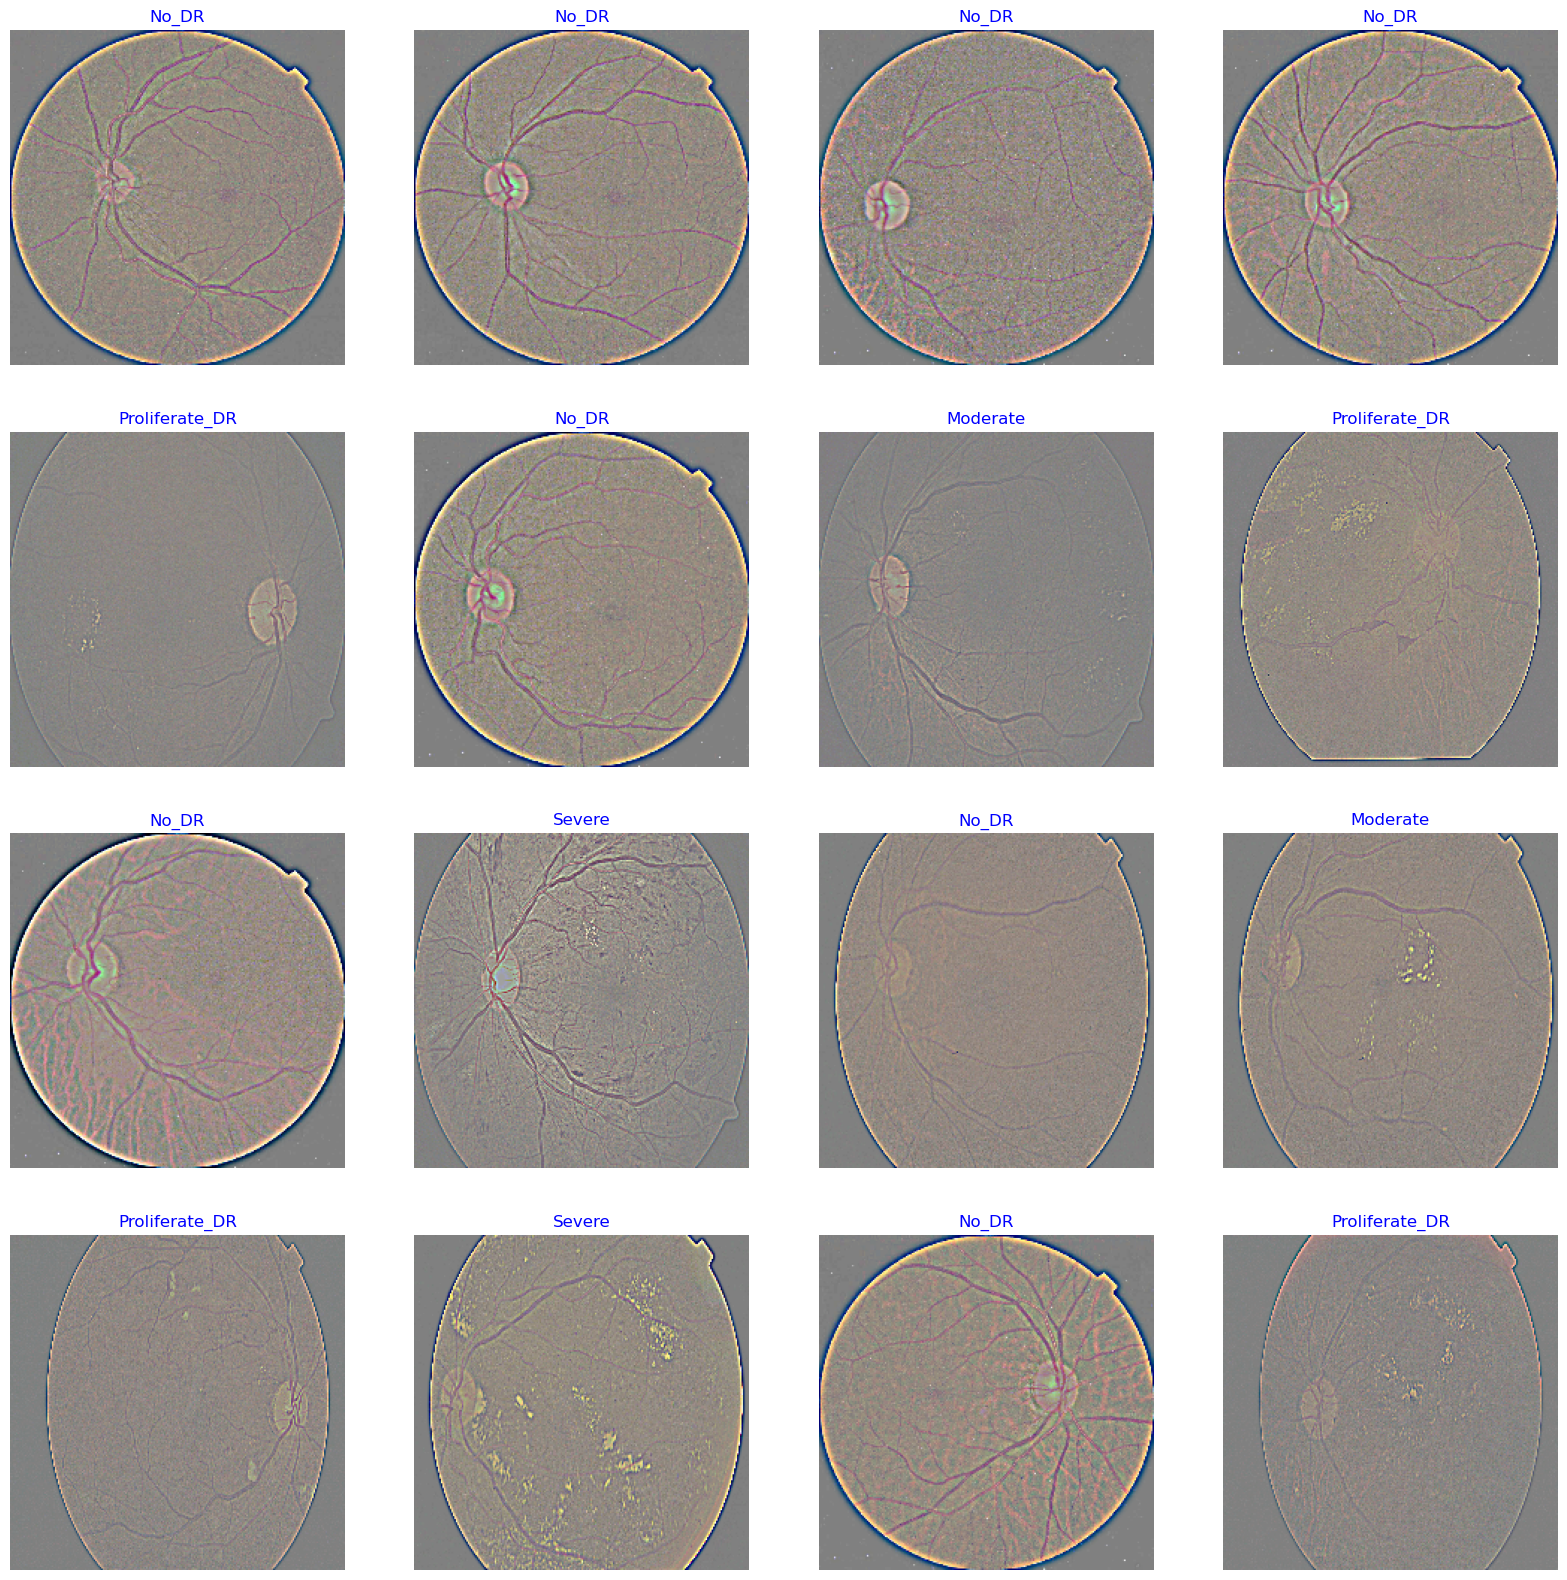

In [32]:
g_dict = train_generator.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_generator)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [34]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys()))

In [47]:
base_model =  tf.keras.applications.ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [50]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D(pool_size=(1,1),strides=(2,2)))
model.add(TimeDistributed(Bidirectional(LSTM(64,return_sequences=True))))
model.add(Dropout(0.5))
model.add(TimeDistributed(LSTM(32, return_sequences=True)))
model.add(Flatten()) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=4, activation="softmax"))

ValueError: Please initialize `Bidirectional` layer with a `tf.keras.layers.Layer` instance. Received: <tensorflow.python.keras.layers.recurrent.LSTM object at 0x0000017106CF9A80>

In [35]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

16705208/16705208 [==============================] - 5s 0us/step


In [43]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 4383912 (16.72 MB)
Trainable params: 43393

In [44]:
epochs =35    #number of all epochs in training

history = model.fit(x= train_generator, epochs= epochs, verbose= 1, validation_data= valid_generator, 
                    validation_steps= None, shuffle= False)

Epoch 1/35
138/138 [==============================] - 327s 2s/step - loss: 5.1893 - accuracy: 0.6380 - val_loss: 3.2998 - val_accuracy: 0.7164
Epoch 2/35
138/138 [==============================] - 308s 2s/step - loss: 2.4795 - accuracy: 0.6963 - val_loss: 1.8164 - val_accuracy: 0.7545
Epoch 3/35
138/138 [==============================] - 304s 2s/step - loss: 1.4343 - accuracy: 0.7195 - val_loss: 1.1144 - val_accuracy: 0.7418
Epoch 4/35
138/138 [==============================] - 293s 2s/step - loss: 0.9127 - accuracy: 0.7423 - val_loss: 0.7232 - val_accuracy: 0.7691
Epoch 5/35
 79/138 [================>.............] - ETA: 1:49 - loss: 0.6784 - accuracy: 0.7555

KeyboardInterrupt: 

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [3]:
CLASSES = [ 'Severe',
            'Proliferate_DR',
            'No_DR',
            'Moderate',
            'Mild']

In [4]:
mri_path = os.path.join(dataset_path, CLASSES[1], '*')
mri_path = glob.glob(mri_path)

In [5]:
mri_path

['C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\001639a390f0.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\0083ee8054ee.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\0243404e8a00.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\02685f13cefd.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\02dda30d3acf.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\0318598cfd16.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\034cb07a550f.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\03a7f4a5786f.png',
 'C:\\Users\\Sriya Nukala\\Downloads\\Dataset\\gaussian_filtered_images\\Proliferate_DR\\07122e268a1d.png',
 'C:\\Users\\Sriya Nukala\\D

In [49]:
IMG_SIZE = 500
IMAGE_SIZE = [500, 500]
DIM = (IMG_SIZE, IMG_SIZE)

In [50]:
work_dr = ID(rescale = 1./255)
train_data_gen = work_dr.flow_from_directory(directory=dataset_path, target_size=DIM, batch_size=6500, shuffle=False)

Found 3662 images belonging to 5 classes.


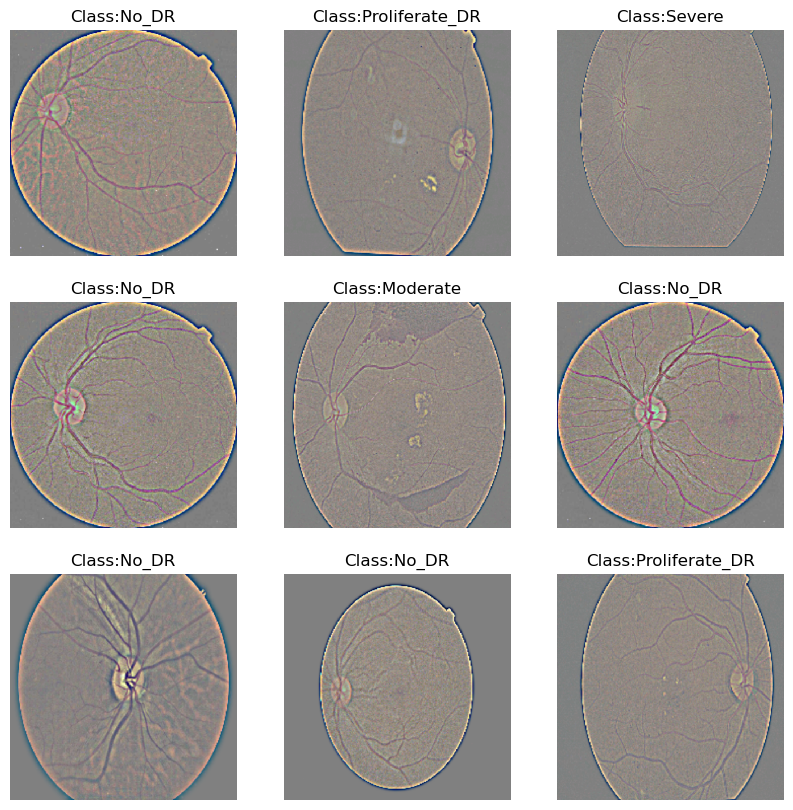

In [53]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 3662)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [35]:
train_data, train_labels = train_data_gen.next()

In [36]:
print(train_data.shape, train_labels.shape)

(3662, 200, 200, 3) (3662, 5)


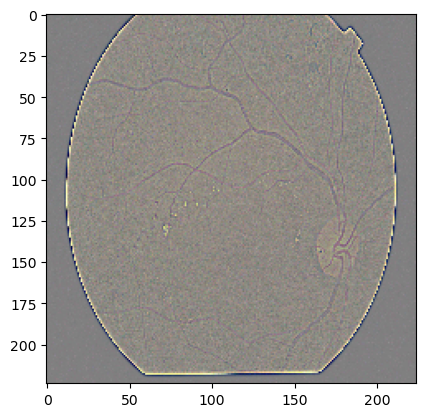

In [39]:
image = io.imread(mri_path[1])  

# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

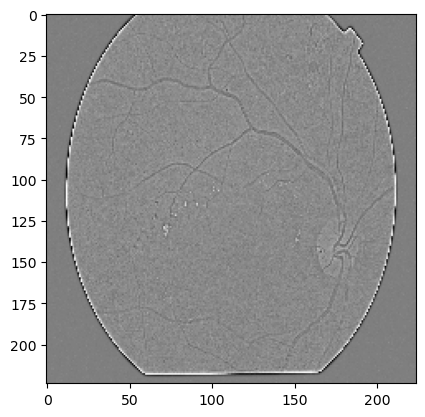

In [42]:
gray_image = scc.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')

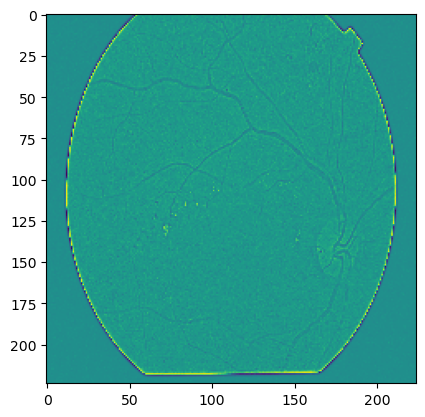

In [43]:
norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
plt.imshow(norm_image)

In [56]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.3, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [59]:
sm = SMOTE(random_state=42)

train_data1, train_labels1 = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data2 = train_data1.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data2.shape, train_labels1.shape)

ValueError: Found input variables with inconsistent numbers of samples: [328, 2050]

In [ ]:
fjkfff